<h1>Parkinson Spiral Exploratory Data Analysis<h1>

<h2>Imports<h2>

In [48]:
import os
import pandas as pd
import numpy as np
import Data_process
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif,SelectKBest, f_classif
from scipy.stats import chi2_contingency
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, make_scorer,silhouette_score,classification_report,roc_curve, auc,confusion_matrix,accuracy_score as acc_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import joblib

<h3>Paths<h3>

In [49]:
parkinson = '../Parkinsons_Data/PARKINSON_HW/hw_dataset/parkinson/'
control = '../Parkinsons_Data/PARKINSON_HW/hw_dataset/control/'
test_dir = "../Parkinsons_Data/PARKINSON_HW/new_dataset/parkinson/"

<h2>Preprocessing<h2>

In [50]:
agg_data = Data_process.aggregate_data(control, parkinson)

# Call the Smooth_scores function
control_smooth_scores = Data_process.Smooth_scores(control)
parkinson_smooth_scores = Data_process.Smooth_scores(parkinson)
agg_data["Smooth"] = control_smooth_scores + parkinson_smooth_scores

# Call the symmetry_scores function
control_symmetry_scores = Data_process.symmetry_scores(control)
parkinson_symmetry_scores = Data_process.symmetry_scores(parkinson)
agg_data["Sym"] = control_symmetry_scores + parkinson_symmetry_scores

#Lift
control_Lift = Data_process.Lift(control)
parkinson_Lift = Data_process.Lift(parkinson)
agg_data["Lift"] = control_Lift + parkinson_Lift

#Time
control_Time = Data_process.Time(control)
parkinson_Time = Data_process.Time(parkinson)
agg_data["Time"] = control_Time + parkinson_Time


In [51]:
Control_df = Data_process.process_directory(control,0)

Parkinson_df = Data_process.process_directory(parkinson,1)

Control_df = pd.concat(Control_df, ignore_index=True)
Parkinson_df = pd.concat(Parkinson_df, ignore_index=True)

combined = Data_process.combined()

<h2>EDA<h2>

<h4>Control Data Summary<h4>

In [52]:
print(Control_df.head())
print(Control_df.info())
print(Control_df.describe())

     X  Y    Z  Pressure   GripAngle  Timestamp  Parkinsons
0  204  0   73       910  1732647300          0           0
1  204  0  218       900  1732647307          0           0
2  204  0  253       900  1732647314          0           0
3  204  0  304       900  1732647321          0           0
4  204  0  351       900  1732647328          0           0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120310 entries, 0 to 120309
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   X           120310 non-null  int64
 1   Y           120310 non-null  int64
 2   Z           120310 non-null  int64
 3   Pressure    120310 non-null  int64
 4   GripAngle   120310 non-null  int64
 5   Timestamp   120310 non-null  int64
 6   Parkinsons  120310 non-null  int64
dtypes: int64(7)
memory usage: 6.4 MB
None
                   X              Y              Z       Pressure  \
count  120310.000000  120310.000000  120310.000000  120310

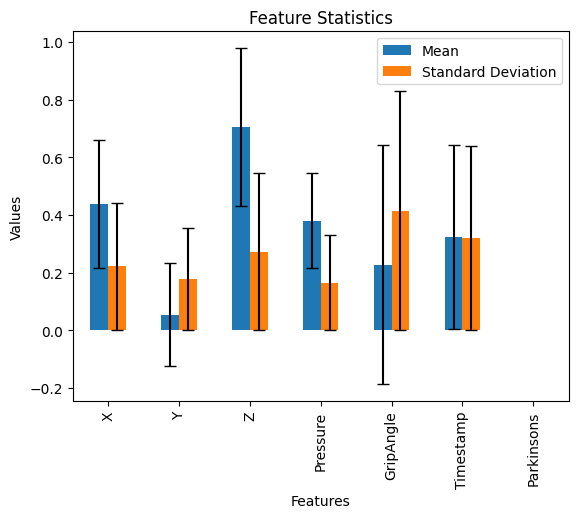

In [53]:
#Normalized to 0 and 1
normalized_df = (Control_df - Control_df.min()) / (Control_df.max() - Control_df.min())
summary = normalized_df.describe()


mean_std = summary.loc[['mean', 'std'], :]


ax = mean_std.transpose().plot(kind='bar', yerr=mean_std.loc['std', :], capsize=4)


ax.set_title('Feature Statistics')
ax.set_xlabel('Features')
ax.set_ylabel('Values')
ax.legend(['Mean', 'Standard Deviation'])


plt.show()

<h4>Parkinson Data Summary<h4>

In [54]:
print(Parkinson_df.head())
print(Parkinson_df.info())
print(Parkinson_df.describe())

     X  Y   Z  Pressure  GripAngle  Timestamp  Parkinsons
0  205  0  15      1440    1351716          0           1
1  205  0  47      1440    1351725          0           1
2  205  0  68      1440    1351734          0           1
3  205  0  84      1420    1351743          0           1
4  205  0  88      1440    1351752          0           1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202659 entries, 0 to 202658
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   X           202659 non-null  int64
 1   Y           202659 non-null  int64
 2   Z           202659 non-null  int64
 3   Pressure    202659 non-null  int64
 4   GripAngle   202659 non-null  int64
 5   Timestamp   202659 non-null  int64
 6   Parkinsons  202659 non-null  int64
dtypes: int64(7)
memory usage: 10.8 MB
None
                   X              Y              Z       Pressure  \
count  202659.000000  202659.000000  202659.000000  202659.000000   


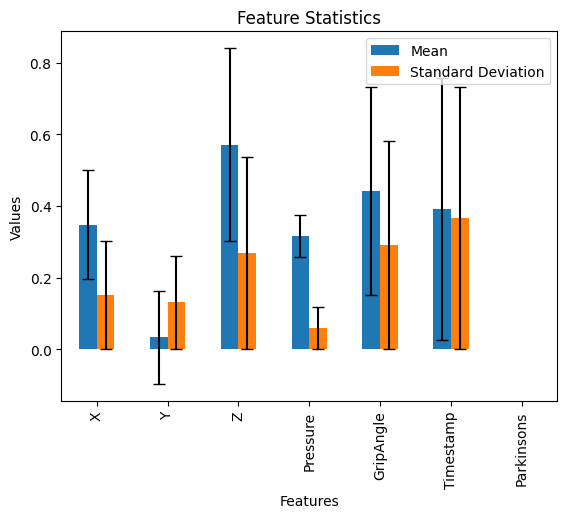

In [55]:
#Normalized to 0 and 1
normalized_PD = (Parkinson_df - Parkinson_df.min()) / (Parkinson_df.max() - Parkinson_df.min())
summary_PD = normalized_PD.describe()


mean_std = summary_PD.loc[['mean', 'std'], :]


ax = mean_std.transpose().plot(kind='bar', yerr=mean_std.loc['std', :], capsize=4)


ax.set_title('Feature Statistics')
ax.set_xlabel('Features')
ax.set_ylabel('Values')
ax.legend(['Mean', 'Standard Deviation'])


plt.show()

<h3>Combined Data Summary<h3>

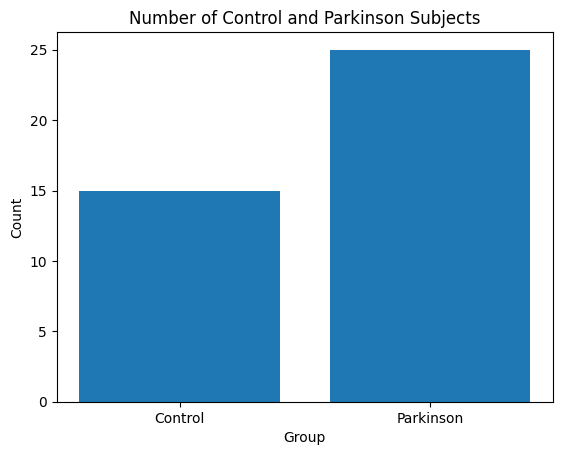

In [56]:

parkinson_counts = agg_data['Parkinsons'].value_counts()

plt.bar(parkinson_counts.index, parkinson_counts.values)
plt.xticks([0, 1], ['Control', 'Parkinson'])
plt.xlabel('Group')
plt.ylabel('Count')
plt.title('Number of Control and Parkinson Subjects')
plt.show()


In [57]:
freq = agg_data['Parkinsons'].value_counts()
percentage = agg_data['Parkinsons'].value_counts(normalize=True) * 100
print("Frequency:\n", freq)
print("Percentage:\n", percentage)

Frequency:
 1    25
0    15
Name: Parkinsons, dtype: int64
Percentage:
 1    62.5
0    37.5
Name: Parkinsons, dtype: float64


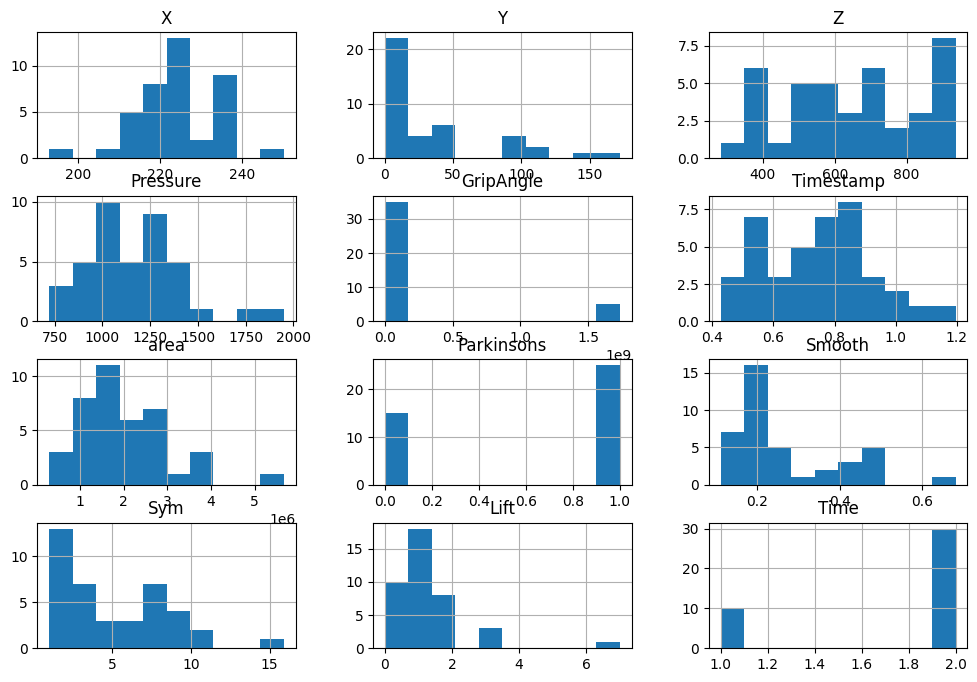

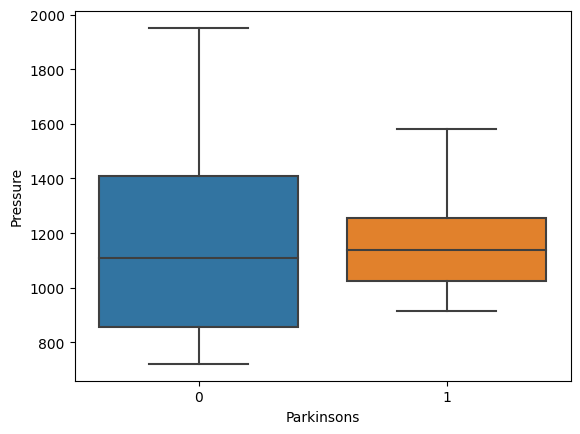

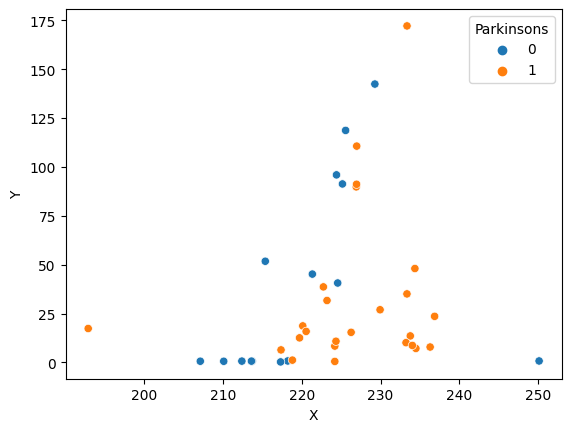

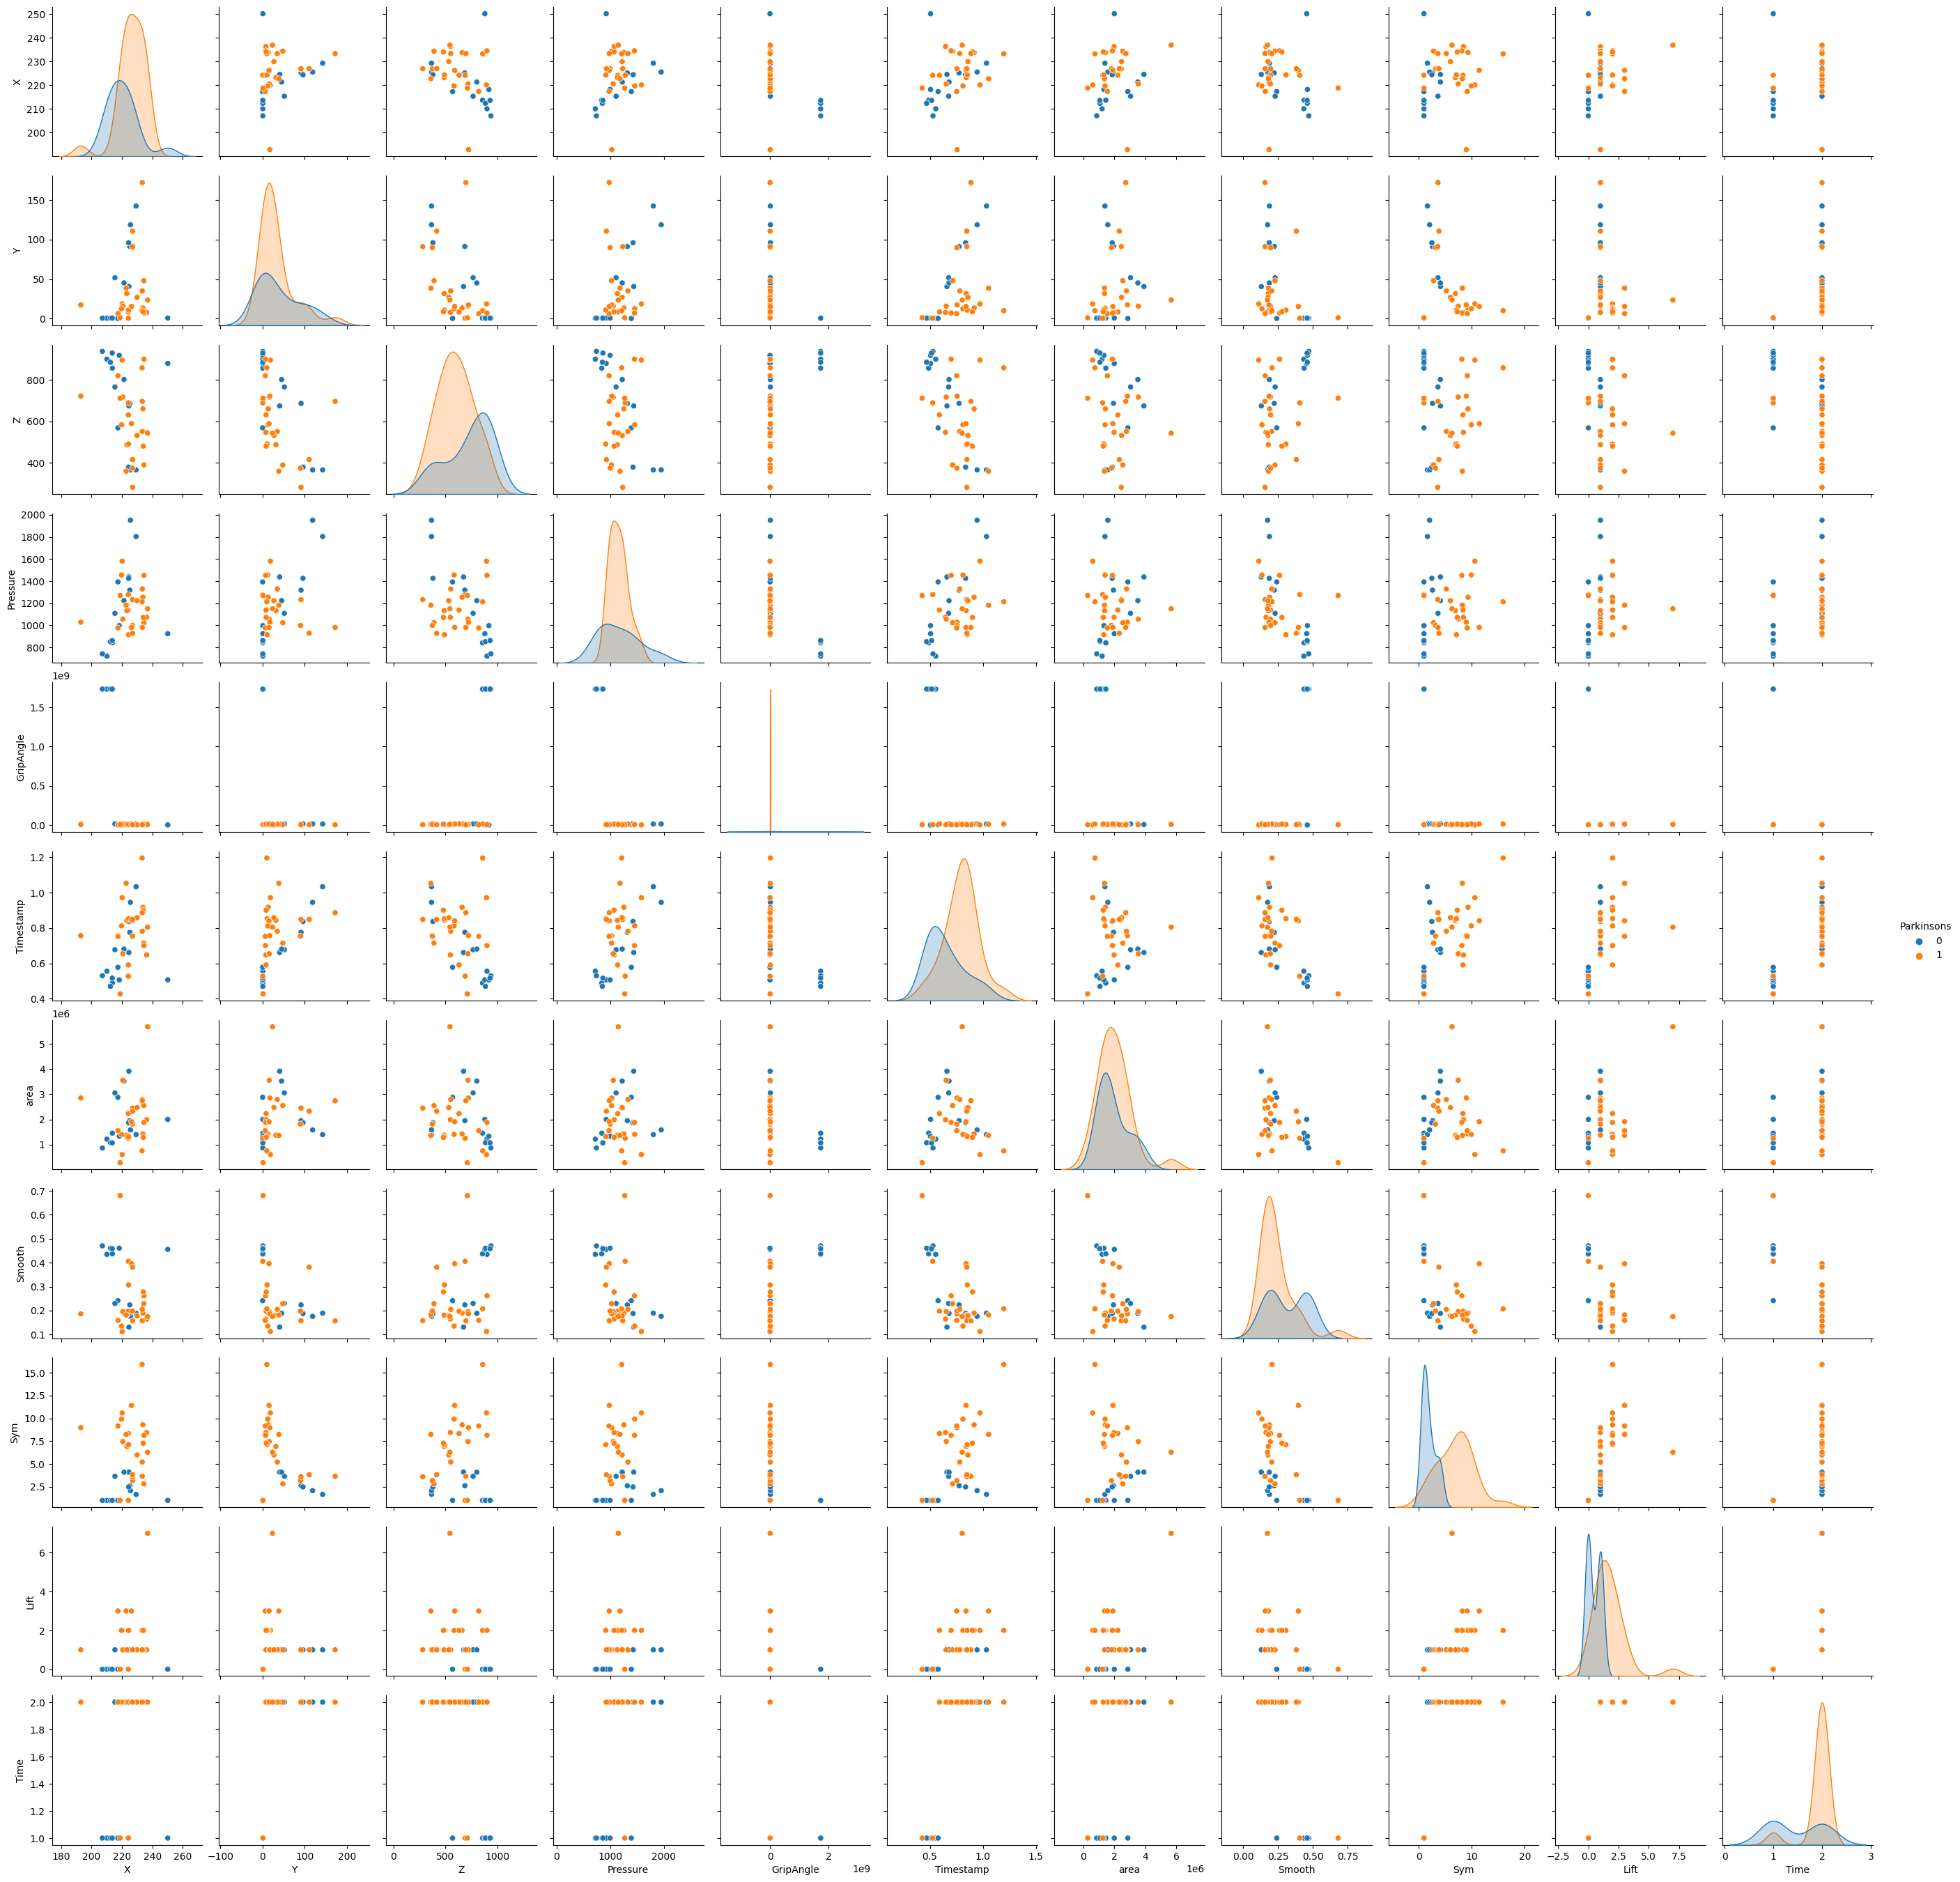

In [58]:
agg_data.hist(figsize=(12, 8))
plt.show()

# Box plots
sns.boxplot(x="Parkinsons", y="Pressure", data=agg_data)
plt.show()

# Scatter plots
sns.scatterplot(x="X", y="Y", hue="Parkinsons", data=agg_data)
plt.show()

# Pair plots
sns.pairplot(agg_data, hue="Parkinsons")
plt.show()

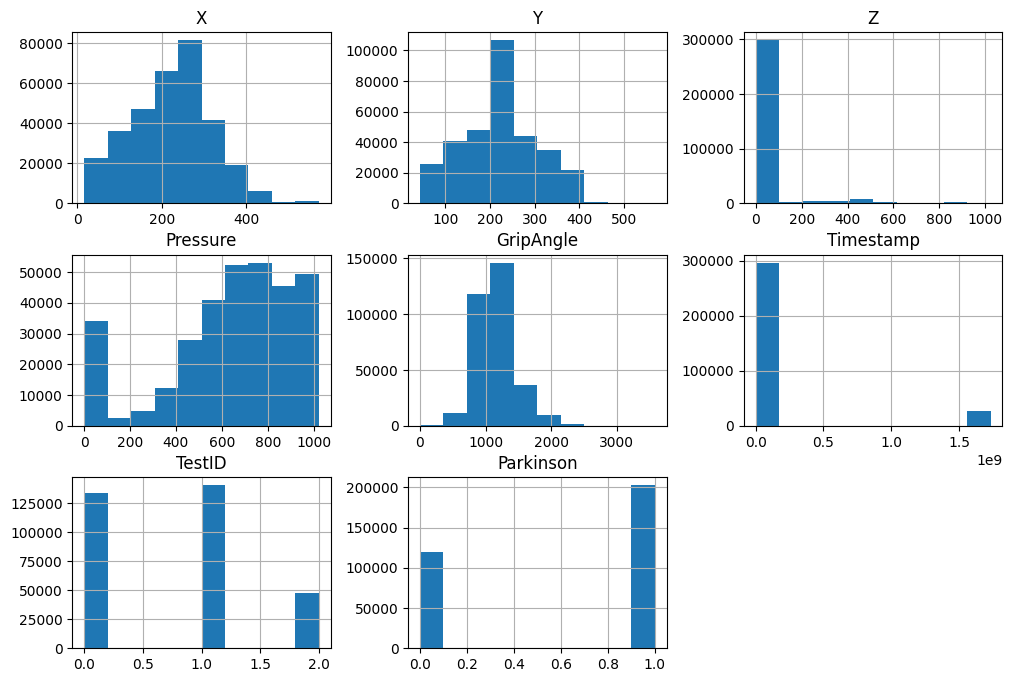

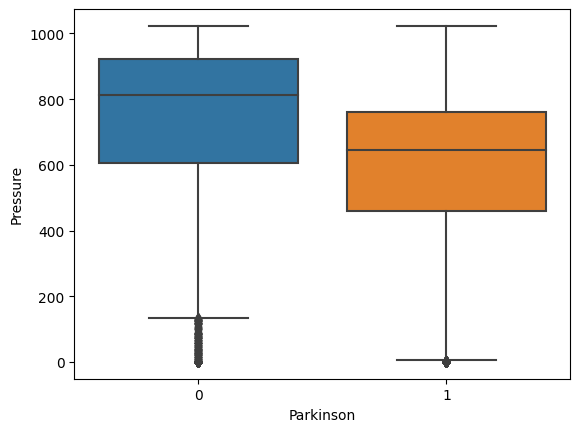

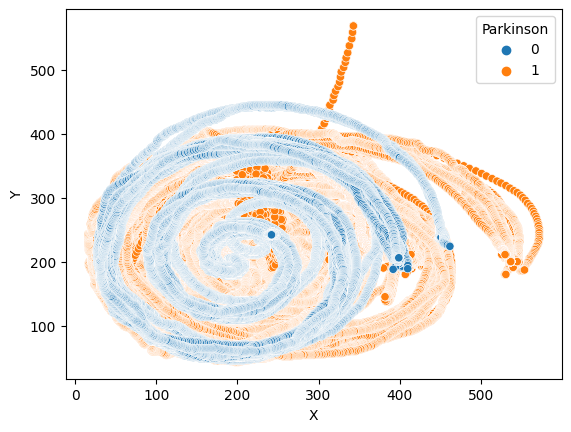

In [59]:
combined.hist(figsize=(12, 8))
plt.show()

# Box plots
sns.boxplot(x="Parkinson", y="Pressure", data=combined)
plt.show()

# Scatter plots
sns.scatterplot(x="X", y="Y", hue="Parkinson", data=combined)
plt.show()



<h2> Correlation<h2>

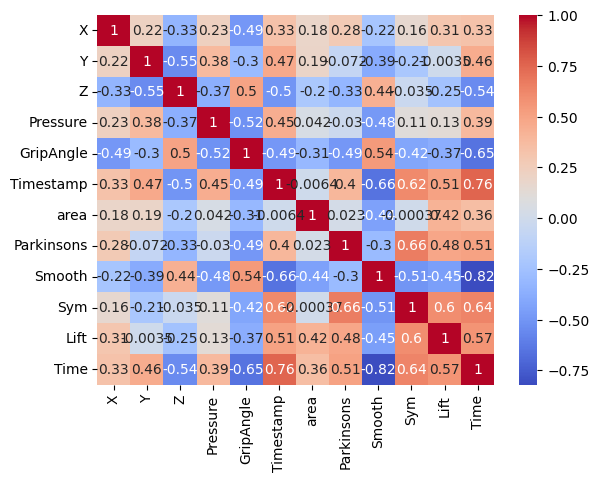

In [60]:
correlations = agg_data.corr()
sns.heatmap(correlations, annot=True, cmap="coolwarm")
plt.show()


<h2>Feature Analysis<h2>

<h3> X Analysis<h3>

<h4>Chi Square<h4>

In [61]:
contingency_table = pd.crosstab(agg_data['X'], agg_data['Parkinsons'])

# Perform the Chi-squared test
chi2, p_value, degrees_of_freedom, expected_freq = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-squared value: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {degrees_of_freedom}")
print("Expected frequencies:")
print(expected_freq)

Chi-squared value: 40.0
P-value: 0.42555940164393696
Degrees of freedom: 39
Expected frequencies:
[[0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]]


<h3> Y Analysis<h3>

<h4>Chi Square<h4>

In [62]:
contingency_table = pd.crosstab(agg_data['Y'], agg_data['Parkinsons'])

# Perform the Chi-squared test
chi2, p_value, degrees_of_freedom, expected_freq = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-squared value: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {degrees_of_freedom}")
print("Expected frequencies:")
print(expected_freq)

Chi-squared value: 40.00000000000001
P-value: 0.42555940164393613
Degrees of freedom: 39
Expected frequencies:
[[0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]]


<h3> Z Analysis <h3>

<h4>Chi Square<h4>

In [63]:
contingency_table = pd.crosstab(agg_data['Z'], agg_data['Parkinsons'])

# Perform the Chi-squared test
chi2, p_value, degrees_of_freedom, expected_freq = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-squared value: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {degrees_of_freedom}")
print("Expected frequencies:")
print(expected_freq)

Chi-squared value: 40.0
P-value: 0.42555940164393696
Degrees of freedom: 39
Expected frequencies:
[[0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]]


<h3> Pressure Analysis<h3>

<h4>Chi Square<h4>

In [64]:
contingency_table = pd.crosstab(agg_data['Pressure'], agg_data['Parkinsons'])

# Perform the Chi-squared test
chi2, p_value, degrees_of_freedom, expected_freq = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-squared value: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {degrees_of_freedom}")
print("Expected frequencies:")
print(expected_freq)

Chi-squared value: 40.0
P-value: 0.42555940164393696
Degrees of freedom: 39
Expected frequencies:
[[0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]]


<h3>Area Analysis <h3>

<h4>Chi Square<h4>

In [65]:
contingency_table = pd.crosstab(agg_data['area'], agg_data['Parkinsons'])

# Perform the Chi-squared test
chi2, p_value, degrees_of_freedom, expected_freq = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-squared value: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {degrees_of_freedom}")
print("Expected frequencies:")
print(expected_freq)

Chi-squared value: 40.0
P-value: 0.42555940164393696
Degrees of freedom: 39
Expected frequencies:
[[0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]]


<h3> Smooth Analysis <h3>

<h4>Chi Square<h4>

In [66]:
contingency_table = pd.crosstab(agg_data['Smooth'], agg_data['Parkinsons'])

# Perform the Chi-squared test
chi2, p_value, degrees_of_freedom, expected_freq = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-squared value: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {degrees_of_freedom}")
print("Expected frequencies:")
print(expected_freq)

Chi-squared value: 40.00000000000001
P-value: 0.42555940164393613
Degrees of freedom: 39
Expected frequencies:
[[0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]]


<h3> Symmetry Analysis<h3>

<h4>Chi Square<h4>

In [67]:
contingency_table = pd.crosstab(agg_data['Sym'], agg_data['Parkinsons'])

# Perform the Chi-squared test
chi2, p_value, degrees_of_freedom, expected_freq = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-squared value: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {degrees_of_freedom}")
print("Expected frequencies:")
print(expected_freq)

Chi-squared value: 33.17333333333334
P-value: 0.3150692874803001
Degrees of freedom: 30
Expected frequencies:
[[3.75  6.25 ]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]
 [0.375 0.625]]


<h3>Lift Analysis<h3>

<h4>Chi Square<h4>

In [68]:
contingency_table = pd.crosstab(agg_data['Lift'], agg_data['Parkinsons'])

# Perform the Chi-squared test
chi2, p_value, degrees_of_freedom, expected_freq = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-squared value: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {degrees_of_freedom}")
print("Expected frequencies:")
print(expected_freq)

Chi-squared value: 14.92148148148148
P-value: 0.004866871197437178
Degrees of freedom: 4
Expected frequencies:
[[ 3.75   6.25 ]
 [ 6.75  11.25 ]
 [ 3.     5.   ]
 [ 1.125  1.875]
 [ 0.375  0.625]]


<h3>Time Analysis<h3>

<h4>Chi Square<h4>

In [69]:
contingency_table = pd.crosstab(agg_data['Time'], agg_data['Parkinsons'])

# Perform the Chi-squared test
chi2, p_value, degrees_of_freedom, expected_freq = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-squared value: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {degrees_of_freedom}")
print("Expected frequencies:")
print(expected_freq)

Chi-squared value: 8.0
P-value: 0.004677734981047276
Degrees of freedom: 1
Expected frequencies:
[[ 3.75  6.25]
 [11.25 18.75]]


<h2>  Feature Importance <h2>

In [70]:

normalized_agg = (agg_data - agg_data.min()) / (agg_data.max() - agg_data.min())

X = normalized_agg.drop('Parkinsons', axis=1)
y = normalized_agg['Parkinsons']

mutual_info = mutual_info_classif(X, y)


feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': mutual_info})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(feature_importance)


      Feature  Importance
8         Sym    0.306358
0           X    0.285021
4   GripAngle    0.247783
1           Y    0.234738
9        Lift    0.187071
3    Pressure    0.133229
7      Smooth    0.130493
10       Time    0.110523
5   Timestamp    0.053630
2           Z    0.000000
6        area    0.000000


<h2> Decision Tree <h2>

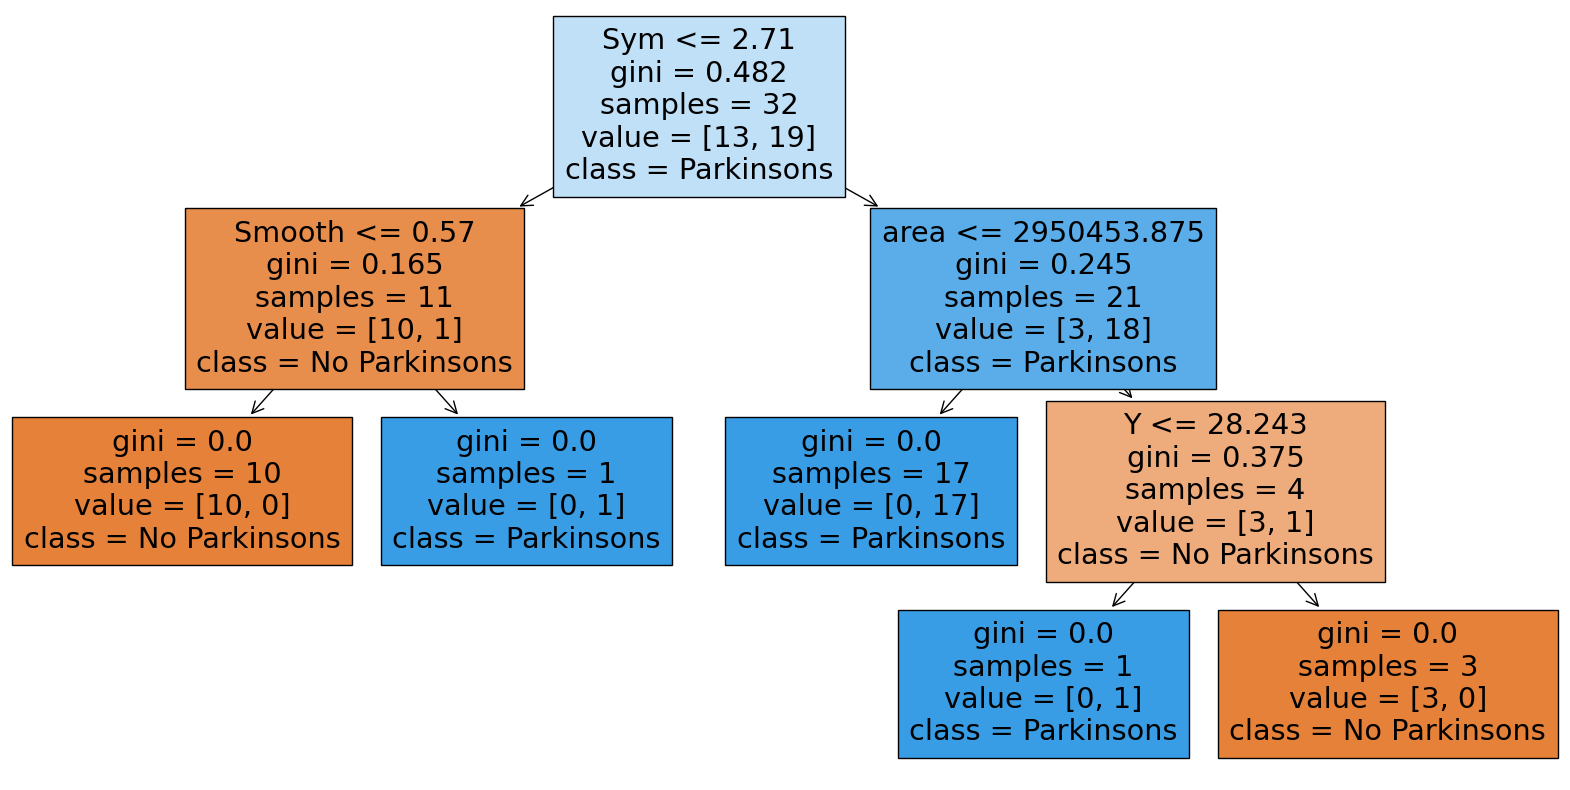

Accuracy: 87.50%


In [71]:
Agg_data = agg_data.drop(columns=['GripAngle', 'Z','Timestamp'])

X = Agg_data.drop(['Parkinsons'], axis=1) 
y = Agg_data['Parkinsons']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)


y_pred = dtc.predict(X_test)


plt.figure(figsize=(20,10))
plot_tree(dtc, filled=True, feature_names=X.columns, class_names=['No Parkinsons', 'Parkinsons'])
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}%'.format(accuracy * 100))

<h2> Random Forest<h2>

In [72]:

X = Agg_data.drop("Parkinsons", axis=1)
y = Agg_data["Parkinsons"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)


importances = rf.feature_importances_


for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance:.4f}")


X: 0.1452
Y: 0.1908
Pressure: 0.1128
area: 0.0877
Smooth: 0.0559
Sym: 0.3076
Lift: 0.0550
Time: 0.0450


<h2>Select K Best Using ANOVA <h2>

In [73]:

X = Agg_data.drop('Parkinsons', axis=1)
y = Agg_data['Parkinsons']

# Select the 5 best features using ANOVA F-value
kbest = SelectKBest(f_classif, k=5)
X_new = kbest.fit_transform(X, y)

selected_features = X.columns[kbest.get_support()]

print("Selected features:", selected_features)


Selected features: Index(['X', 'Smooth', 'Sym', 'Lift', 'Time'], dtype='object')


<h2>Clustering<h2>

<h4>Lift and Time Cluster<h4>

Silhouette Score: 0.8004513217118662


c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


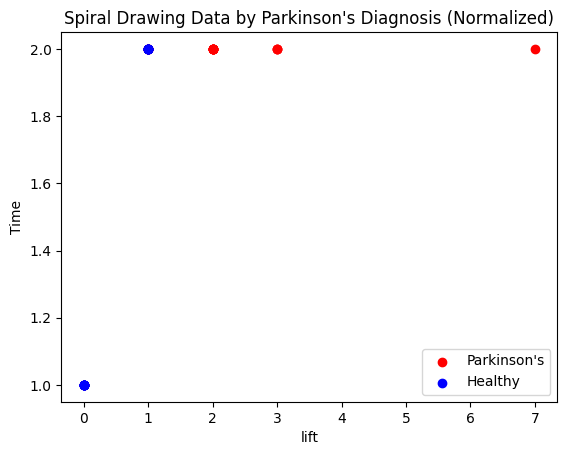

['kmeans_scaler.joblib']

In [74]:

X = agg_data[['Lift', 'Time']].to_numpy()

scaler = StandardScaler()
X = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

cluster_labels = kmeans.predict(X)

sil_score = silhouette_score(X, cluster_labels)
print("Silhouette Score:", sil_score)

agg_data['cluster'] = cluster_labels
parkinsons = agg_data[agg_data['Parkinsons'] == 1]
healthy = agg_data[agg_data['Parkinsons'] == 0]

plt.scatter(parkinsons['Lift'], parkinsons['Time'], color='red', label='Parkinson\'s')
plt.scatter(healthy['Lift'], healthy['Time'], color='blue', label='Healthy')
plt.xlabel('lift')
plt.ylabel('Time')
plt.title('Spiral Drawing Data by Parkinson\'s Diagnosis (Normalized)')
plt.legend()
plt.show()

# Save the KMeans model
joblib.dump(kmeans, 'kmeans_model.joblib')

# Save the scaler
joblib.dump(scaler, 'kmeans_scaler.joblib')


<h4>Lift and X Cluster<h4>

c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.42033698846995177


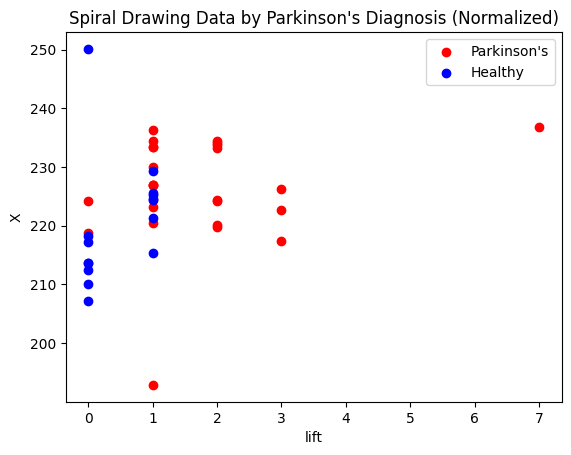

In [75]:

X = agg_data[['Lift', 'X']].to_numpy()

scaler = StandardScaler()
X = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

cluster_labels = kmeans.predict(X)

sil_score = silhouette_score(X, cluster_labels)
print("Silhouette Score:", sil_score)

agg_data['cluster'] = cluster_labels
parkinsons = agg_data[agg_data['Parkinsons'] == 1]
healthy = agg_data[agg_data['Parkinsons'] == 0]

plt.scatter(parkinsons['Lift'], parkinsons['X'], color='red', label='Parkinson\'s')
plt.scatter(healthy['Lift'], healthy['X'], color='blue', label='Healthy')
plt.xlabel('lift')
plt.ylabel('X')
plt.title('Spiral Drawing Data by Parkinson\'s Diagnosis (Normalized)')
plt.legend()
plt.show()


<h4>Lift and Symmetry Cluster<h4>

Silhouette Score: 0.5770040296864859


c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


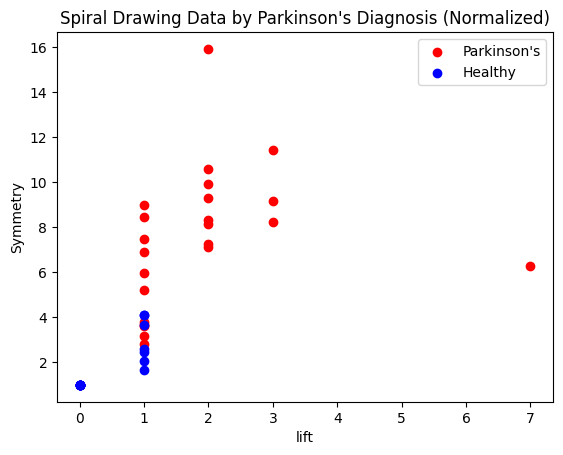

In [76]:

X = agg_data[['Lift', 'Sym']].to_numpy()

scaler = StandardScaler()
X = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

cluster_labels = kmeans.predict(X)

sil_score = silhouette_score(X, cluster_labels)
print("Silhouette Score:", sil_score)

agg_data['cluster'] = cluster_labels
parkinsons = agg_data[agg_data['Parkinsons'] == 1]
healthy = agg_data[agg_data['Parkinsons'] == 0]

plt.scatter(parkinsons['Lift'], parkinsons['Sym'], color='red', label='Parkinson\'s')
plt.scatter(healthy['Lift'], healthy['Sym'], color='blue', label='Healthy')
plt.xlabel('lift')
plt.ylabel('Symmetry')
plt.title('Spiral Drawing Data by Parkinson\'s Diagnosis (Normalized)')
plt.legend()
plt.show()


<h4>Lift and Smooth Cluster<h4>

c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.6195390589336549


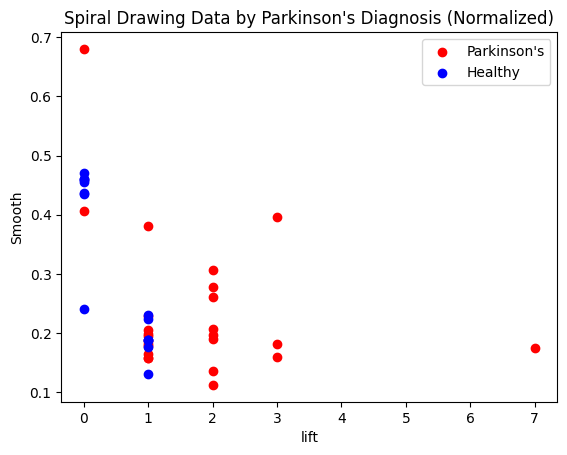

In [77]:

X = agg_data[['Lift', 'Smooth']].to_numpy()

# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

cluster_labels = kmeans.predict(X)

sil_score = silhouette_score(X, cluster_labels)
print("Silhouette Score:", sil_score)

agg_data['cluster'] = cluster_labels
parkinsons = agg_data[agg_data['Parkinsons'] == 1]
healthy = agg_data[agg_data['Parkinsons'] == 0]

plt.scatter(parkinsons['Lift'], parkinsons['Smooth'], color='red', label='Parkinson\'s')
plt.scatter(healthy['Lift'], healthy['Smooth'], color='blue', label='Healthy')
plt.xlabel('lift')
plt.ylabel('Smooth')
plt.title('Spiral Drawing Data by Parkinson\'s Diagnosis (Normalized)')
plt.legend()
plt.show()


<h2>Models<h2>

<h3>Random Forest<h3>

In [78]:

selected_features = ['X', 'Smooth', 'Sym', 'Lift', 'Time']
X = agg_data[selected_features]
y = agg_data['Parkinsons']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.88
Classification report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.83      0.91         6

    accuracy                           0.88         8
   macro avg       0.83      0.92      0.85         8
weighted avg       0.92      0.88      0.88         8



<h3>Random Forest with K means <h3>

In [79]:
kmeans_features = ['Lift', 'Sym']
kmeans_data = agg_data[kmeans_features]
k = 2  
kmeans = KMeans(n_clusters=k, random_state=42)
agg_data['cluster'] = kmeans.fit_predict(kmeans_data)


selected_features = ['X', 'Smooth', 'Sym', 'Lift', 'Time', 'cluster']
X = agg_data[selected_features]
y = agg_data['Parkinsons']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)


y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification report:")
print(classification_report(y_test, y_pred))

c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy: 0.88
Classification report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.83      0.91         6

    accuracy                           0.88         8
   macro avg       0.83      0.92      0.85         8
weighted avg       0.92      0.88      0.88         8



<h3> With Tunning and K-Fold<h3>

In [80]:

kmeans_features = ['Lift', 'Time']
kmeans_data = agg_data[kmeans_features]
scaler_kmeans = StandardScaler()
kmeans_data = scaler_kmeans.fit_transform(kmeans_data)

k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
agg_data['cluster'] = kmeans.fit_predict(kmeans_data)

selected_features = ['X', 'Smooth', 'Sym', 'Lift', 'Time']
X = agg_data[selected_features]
y = agg_data['Parkinsons']


scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(rf_classifier, param_grid, cv=cv, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score:.2f}")

best_rf_classifier = grid_search.best_estimator_
best_rf_classifier.fit(X_train, y_train)

y_pred = best_rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best cross-validation score: 0.85
Accuracy: 0.88
Classification report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.83      0.91         6

    accuracy                           0.88         8
   macro avg       0.83      0.92      0.85         8
weighted avg       0.92      0.88      0.88         8



<h3>AUC-ROC<h3>

AUC-ROC: 0.92


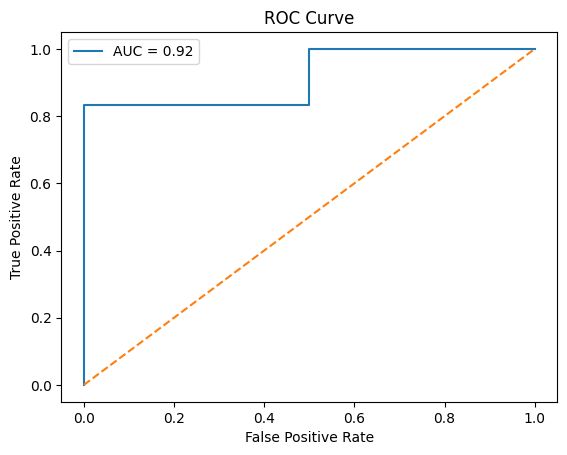

In [81]:

rf_classifier.fit(X_train, y_train)


y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)


auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC-ROC: {auc_score:.2f}")

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


<h2>SVM<h2>

In [82]:
selected_features = ['X', 'Smooth', 'Sym', 'Lift', 'Time']
X = agg_data[selected_features]
y = agg_data['Parkinsons']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svm_classifier = SVC(kernel='linear', random_state=42)


param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}


grid_search = GridSearchCV(svm_classifier, param_grid, cv=KFold(n_splits=5), verbose=2)


grid_search.fit(X_train, y_train)


best_svm_classifier = grid_search.best_estimator_
y_pred = best_svm_classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1

<h3>SVM with K means<h3>

In [94]:

kmeans_features = ['Lift', 'Time']
kmeans_data = agg_data[kmeans_features]
scaler_kmeans = StandardScaler()
kmeans_data = scaler_kmeans.fit_transform(kmeans_data)

k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
agg_data['cluster'] = kmeans.fit_predict(kmeans_data)

selected_features = ['X', 'Smooth', 'Sym', 'Lift', 'Time', 'cluster']
X = agg_data[selected_features]
y = agg_data['Parkinsons']

scaler_svm = StandardScaler()
X = scaler_svm.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm_classifier = SVC(kernel='linear', random_state=42)


param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}


grid_search = GridSearchCV(svm_classifier, param_grid, scoring='roc_auc', cv=5, verbose=1)

grid_search.fit(X_train, y_train)


print("Best parameters found: ", grid_search.best_params_)
print("Best AUC-ROC score on training data: ", grid_search.best_score_)


best_svm_classifier = grid_search.best_estimator_


y_pred = best_svm_classifier.predict(X_test)

auc_roc = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC: {auc_roc:.2f}")

print("Classification report:")
print(classification_report(y_test, y_pred))


c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'C': 0.1, 'gamma': 1}
Best AUC-ROC score on training data:  0.8944444444444445
AUC-ROC: 0.67
Classification report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.83      0.83      0.83         6

    accuracy                           0.75         8
   macro avg       0.67      0.67      0.67         8
weighted avg       0.75      0.75      0.75         8



<h3>AUC ROC<h3>

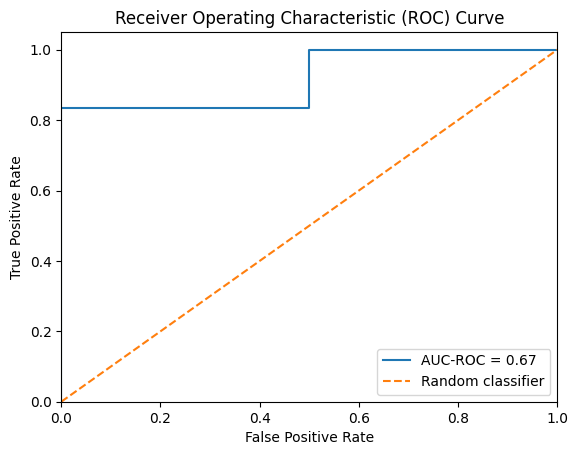

In [95]:
y_pred_proba = best_svm_classifier.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

#Plot 
plt.figure()
plt.plot(fpr, tpr, label=f"AUC-ROC = {auc_roc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

<h2> Neural Network<h2>

In [84]:

def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(32, input_dim=len(selected_features), activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


selected_features = ['X', 'Smooth', 'Sym', 'Lift', 'Time','area']
X = agg_data[selected_features]
y = agg_data['Parkinsons']

scaler = StandardScaler()
X = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


keras_classifier = KerasClassifier(build_fn=create_model, verbose=0)

param_grid = {
    'epochs': [10, 20],
    'batch_size': [10, 20],
    'optimizer': ['adam', 'rmsprop']
}


grid_search = GridSearchCV(estimator=keras_classifier, param_grid=param_grid, cv=KFold(n_splits=5), verbose=2)

grid_search.fit(X_train, y_train)

best_neural_network = grid_search.best_estimator_
y_pred = np.round(best_neural_network.predict(X_test))


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification report:")
print(classification_report(y_test, y_pred))


C:\Users\wilso\AppData\Local\Temp\ipykernel_15680\2806458920.py:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_classifier = KerasClassifier(build_fn=create_model, verbose=0)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ...........batch_size=10, epochs=10, optimizer=adam; total time=   1.3s
[CV] END ...........batch_size=10, epochs=10, optimizer=adam; total time=   1.1s
[CV] END ...........batch_size=10, epochs=10, optimizer=adam; total time=   1.0s
[CV] END ...........batch_size=10, epochs=10, optimizer=adam; total time=   1.0s
[CV] END ...........batch_size=10, epochs=10, optimizer=adam; total time=   1.2s
[CV] END ........batch_size=10, epochs=10, optimizer=rmsprop; total time=   0.9s
[CV] END ........batch_size=10, epochs=10, optimizer=rmsprop; total time=   1.0s
[CV] END ........batch_size=10, epochs=10, optimizer=rmsprop; total time=   1.1s
[CV] END ........batch_size=10, epochs=10, optimizer=rmsprop; total time=   0.9s
[CV] END ........batch_size=10, epochs=10, optimizer=rmsprop; total time=   1.4s
[CV] END ...........batch_size=10, epochs=20, optimizer=adam; total time=   1.1s
[CV] END ...........batch_size=10, epochs=20, opt

<h3> Neural Network with K-Means<h3>

In [96]:

kmeans_features = ['Lift', 'Time']
kmeans_data = agg_data[kmeans_features]
scaler_kmeans = StandardScaler()
kmeans_data = scaler_kmeans.fit_transform(kmeans_data)

k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
agg_data['cluster'] = kmeans.fit_predict(kmeans_data)

selected_features = ['X', 'Smooth', 'Sym', 'Lift', 'Time', 'cluster']
X = agg_data[selected_features]
y = agg_data['Parkinsons']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(units=32, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

keras_classifier = KerasClassifier(build_fn=create_model, verbose=0)

param_grid = {
    'epochs': [10, 20],
    'batch_size': [10, 20],
    'optimizer': ['adam', 'rmsprop']
}

grid_search = GridSearchCV(estimator=keras_classifier, param_grid=param_grid, cv=KFold(n_splits=25), verbose=2)

grid_search.fit(X_train, y_train)

best_neural_network = grid_search.best_estimator_
y_pred = np.round(best_neural_network.predict(X_test))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification report:")
print(classification_report(y_test, y_pred))


c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\wilso\AppData\Local\Temp\ipykernel_15680\713029395.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_classifier = KerasClassifier(build_fn=create_model, verbose=0)


Fitting 25 folds for each of 8 candidates, totalling 200 fits
[CV] END ...........batch_size=10, epochs=10, optimizer=adam; total time=   0.9s
[CV] END ...........batch_size=10, epochs=10, optimizer=adam; total time=   1.7s
[CV] END ...........batch_size=10, epochs=10, optimizer=adam; total time=   0.7s
[CV] END ...........batch_size=10, epochs=10, optimizer=adam; total time=   0.7s
[CV] END ...........batch_size=10, epochs=10, optimizer=adam; total time=   0.7s
[CV] END ...........batch_size=10, epochs=10, optimizer=adam; total time=   0.9s
[CV] END ...........batch_size=10, epochs=10, optimizer=adam; total time=   1.0s
[CV] END ...........batch_size=10, epochs=10, optimizer=adam; total time=   0.9s
[CV] END ...........batch_size=10, epochs=10, optimizer=adam; total time=   0.9s
[CV] END ...........batch_size=10, epochs=10, optimizer=adam; total time=   0.8s
[CV] END ...........batch_size=10, epochs=10, optimizer=adam; total time=   1.1s
[CV] END ...........batch_size=10, epochs=10, o

TypeError: 'numpy.float64' object is not callable

<h2>GBM<h2>

In [86]:
kmeans_features = ['Lift', 'Time']
kmeans_data = agg_data[kmeans_features]
scaler_kmeans = StandardScaler()
kmeans_data = scaler_kmeans.fit_transform(kmeans_data)

k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
agg_data['cluster'] = kmeans.fit_predict(kmeans_data)

selected_features = ['X', 'Smooth', 'Sym', 'Lift', 'Time', 'cluster']


X = agg_data[selected_features]
y = agg_data['Parkinsons']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)


gbm.fit(X_train, y_train)


y_pred = gbm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


print("Classification report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.88
Classification report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.83      0.91         6

    accuracy                           0.88         8
   macro avg       0.83      0.92      0.85         8
weighted avg       0.92      0.88      0.88         8



c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<h3>GBM with Forward Selection<h3>

In [87]:



kmeans_features = ['Lift', 'Time']
kmeans_data = agg_data[kmeans_features]
scaler_kmeans = StandardScaler()
kmeans_data = scaler_kmeans.fit_transform(kmeans_data)

k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
agg_data['cluster'] = kmeans.fit_predict(kmeans_data)

selected_features = ['X', 'Smooth', 'Sym', 'Lift', 'Time', 'cluster']

X = agg_data[selected_features]
y = agg_data['Parkinsons']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Gradient Boosting Classifier without forward selection
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification report:")
print(classification_report(y_test, y_pred))

#Forward selection
gbm_fs = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

sfs = SFS(gbm_fs, 
          k_features='best',
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=5,
          n_jobs=-1)

X_train_fs = X_train.copy()
X_test_fs = X_test.copy()
sfs.fit(X_train_fs, y_train)


selected_indices = list(sfs.k_feature_idx_)
selected_features_fs = [selected_features[i] for i in selected_indices]

print(f"Selected features after forward selection: {selected_features_fs}")


X_train_fs = X_train_fs[:, selected_indices]
X_test_fs = X_test_fs[:, selected_indices]


gbm_fs.fit(X_train_fs, y_train)
y_pred_fs = gbm_fs.predict(X_test_fs)

accuracy_fs = accuracy_score(y_test, y_pred_fs)
print(f"Accuracy after forward selection: {accuracy_fs:.2f}")

print("Classification report after forward selection:")
print(classification_report(y_test, y_pred_fs))


c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy: 0.88
Classification report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.83      0.91         6

    accuracy                           0.88         8
   macro avg       0.83      0.92      0.85         8
weighted avg       0.92      0.88      0.88         8

Selected features after forward selection: ['X', 'Smooth', 'Sym', 'Lift']
Accuracy after forward selection: 0.88
Classification report after forward selection:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.83      0.91         6

    accuracy                           0.88         8
   macro avg       0.83      0.92      0.85         8
weighted avg       0.92      0.88      0.88         8



<h2> Regression Model<h2>

In [97]:

kmeans_features = ['Lift', 'Time']
kmeans_data = agg_data[kmeans_features]
scaler_kmeans = StandardScaler()
kmeans_data = scaler_kmeans.fit_transform(kmeans_data)

k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
agg_data['cluster'] = kmeans.fit_predict(kmeans_data)

selected_features = ['X', 'Smooth', 'Sym', 'Lift', 'Time', 'cluster']
X = agg_data[selected_features]
y = agg_data['Parkinsons']  
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


log_reg = LogisticRegression()


log_reg.fit(X_train, y_train)


y_pred = log_reg.predict(X_test)


print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


Confusion Matrix:
 [[2 0]
 [1 5]]

Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.83      0.91         6

    accuracy                           0.88         8
   macro avg       0.83      0.92      0.85         8
weighted avg       0.92      0.88      0.88         8



c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


TypeError: 'numpy.float64' object is not callable

<h3>logistic With Gridsearch<h3>

In [89]:


kmeans_features = ['Lift', 'Time']
kmeans_data = agg_data[kmeans_features]
scaler_kmeans = StandardScaler()
kmeans_data = scaler_kmeans.fit_transform(kmeans_data)

k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
agg_data['cluster'] = kmeans.fit_predict(kmeans_data)

selected_features = ['X', 'Smooth', 'Sym', 'Lift', 'Time', 'cluster', 'Y']
X = agg_data[selected_features]
y = agg_data['Parkinsons']

scaler = StandardScaler()
X = scaler.fit_transform(X)


log_reg = LogisticRegression()

param_grid = {
    'C': np.logspace(-4, 4, 9),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
test_sizes = [0.2, 0.3, 0.4]

best_score = 0
best_params = None
best_test_size = None


for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    grid_search = GridSearchCV(log_reg, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    score = grid_search.best_score_
    if score > best_score:
        best_score = score
        best_params = grid_search.best_params_
        best_test_size = test_size

print(f"Best hyperparameters: {best_params}")
print(f"Best test size: {best_test_size}")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_test_size, random_state=42)
best_model = LogisticRegression(**best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)


print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Best hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best test size: 0.4
Confusion Matrix:
 [[5 1]
 [3 7]]

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.88      0.70      0.78        10

    accuracy                           0.75        16
   macro avg       0.75      0.77      0.75        16
weighted avg       0.78      0.75      0.75        16

Accuracy Score: 0.75


<h2>XGboost<h2>

c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Best hyperparameters found by GridSearchCV:
{'alpha': 0, 'colsample_bytree': 0.8, 'lambda': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}


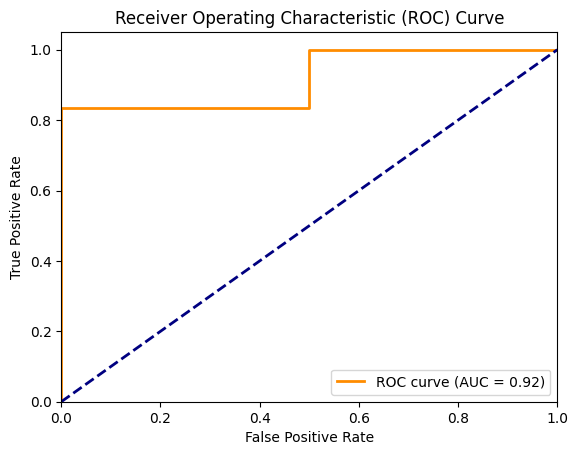

Accuracy: 0.88
Classification report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.83      0.91         6

    accuracy                           0.88         8
   macro avg       0.83      0.92      0.85         8
weighted avg       0.92      0.88      0.88         8



In [90]:

kmeans_features = ['Lift', 'Time']
kmeans_data = agg_data[kmeans_features]
scaler_kmeans = StandardScaler()
kmeans_data = scaler_kmeans.fit_transform(kmeans_data)

k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
agg_data['cluster'] = kmeans.fit_predict(kmeans_data)

selected_features = ['X', 'Smooth', 'Sym', 'Lift', 'Time', 'cluster', 'Y', 'area']
X = agg_data[selected_features]
y = agg_data['Parkinsons']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)


param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    'alpha': [0, 0.1, 1],
    'lambda': [0, 0.1, 1],
    'n_estimators': [100, 200, 300]
}


grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)


print("Best hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)


best_xgb_clf = grid_search.best_estimator_
best_xgb_clf.fit(X_train, y_train)


y_pred = best_xgb_clf.predict(X_test)


y_pred_proba = best_xgb_clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification report:")
print(classification_report(y_test, y_pred))

In [91]:

def xgb_cv_kfold(n_folds, X, y, param_grid):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='accuracy', cv=kf, n_jobs=-1)
    grid_search.fit(X, y)
    best_estimator = grid_search.best_estimator_
    cv_accuracy_scores = cross_val_score(best_estimator, X, y, cv=kf, scoring='accuracy')
    cv_f1_scores = cross_val_score(best_estimator, X, y, cv=kf, scoring='f1')
    return np.mean(cv_accuracy_scores), np.mean(cv_f1_scores)

kmeans_features = ['Lift', 'Time']
kmeans_data = agg_data[kmeans_features]
scaler_kmeans = StandardScaler()
kmeans_data = scaler_kmeans.fit_transform(kmeans_data)

k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
agg_data['cluster'] = kmeans.fit_predict(kmeans_data)

selected_features = ['X', 'Smooth', 'Sym', 'Lift', 'Time', 'cluster', 'Y', 'area']
X = agg_data[selected_features]
y = agg_data['Parkinsons']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    'alpha': [0, 0.1, 1],
    'lambda': [0, 0.1, 1],
    'n_estimators': [100, 200, 300]
}

n_folds = 5

accuracy_score, f1_score = xgb_cv_kfold(n_folds, X_train, y_train, param_grid)
print(f"n_folds: {n_folds}, accuracy score: {accuracy_score:.4f}, f1 score: {f1_score:.4f}")

kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='accuracy', cv=kf, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best hyperparameters: {grid_search.best_params_}")



c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost

n_folds: 5, accuracy score: 0.9429, f1 score: 0.9333


c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Best hyperparameters: {'alpha': 1, 'colsample_bytree': 1, 'lambda': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


Best hyperparameters: {'alpha': 1, 'colsample_bytree': 1, 'lambda': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


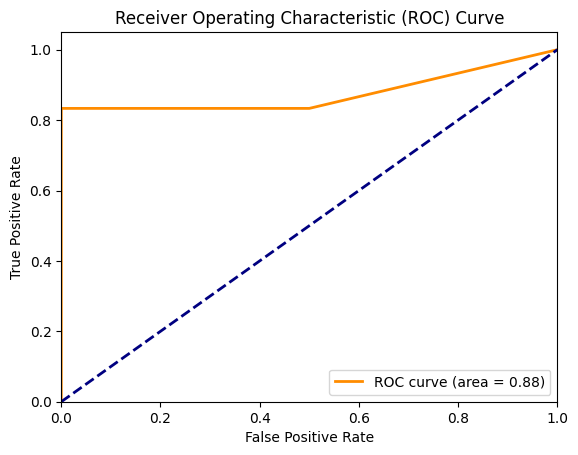

In [92]:
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='accuracy', cv=kf, n_jobs=-1)
grid_search.fit(X_train, y_train)


print(f"Best hyperparameters: {grid_search.best_params_}")


y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]


fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



<h3>K Nearest Neighbors <h3>

In [93]:

kmeans_features = ['Lift', 'Time']
kmeans_data = agg_data[kmeans_features]
scaler_kmeans = StandardScaler()
kmeans_data = scaler_kmeans.fit_transform(kmeans_data)

k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
agg_data['cluster'] = kmeans.fit_predict(kmeans_data)

selected_features = ['X', 'Smooth', 'Sym', 'Lift', 'Time', 'cluster', 'Y', 'area']
X = agg_data[selected_features]
y = agg_data['Parkinsons']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


max_accuracy = 0
best_k = 1
for k in range(1, 21):  #Test k values from 1 to 20
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    knn_clf.fit(X_train, y_train)
    y_pred = knn_clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    if acc > max_accuracy:
        max_accuracy = acc
        best_k = k

knn_clf = KNeighborsClassifier(n_neighbors=best_k)
knn_clf.fit(X_train, y_train)

y_pred = knn_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Optimal k: {best_k}")
print(f"Accuracy: {accuracy:.2f}")

print("Classification report:")
print(classification_report(y_test, y_pred))



c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


TypeError: 'numpy.float64' object is not callable

<h2>Comparing Models <h2>

In [ ]:

kmeans_features = ['Lift', 'Time']
kmeans_data = agg_data[kmeans_features]
scaler_kmeans = StandardScaler()
kmeans_data = scaler_kmeans.fit_transform(kmeans_data)

k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
agg_data['cluster'] = kmeans.fit_predict(kmeans_data)

selected_features = ["Smooth",'Y', 'Sym', 'Lift', 'Time']
X = agg_data[selected_features]
y = agg_data['Parkinsons']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = [
    {
        'name': 'Logistic Regression',
        'model': LogisticRegression(random_state=42),
        'param_grid': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100]
        }
    },
    {
        'name': 'Random Forest',
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'n_estimators': [10, 50, 100, 200],
            'max_depth': [None, 3, 5, 10],
            'min_samples_split': [2, 5, 10]
        }
    },
    {
        'name': 'K-Nearest Neighbors',
        'model': KNeighborsClassifier(),
        'param_grid': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance']
        }
    },
    {
        'name': 'SVM',
        'model': SVC(random_state=42, probability=True),
        'param_grid': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf']
        }
    },
    {
        'name': 'Neural Network',
        'model': MLPClassifier(random_state=42),
        'param_grid': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'activation': ['tanh', 'relu'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive']
        }
    },
    {
        'name': 'XGBoost',
        'model': xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        'param_grid': {
            'max_depth': [3, 4, 5, 6],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1],
            'colsample_bytree': [0.8, 0.9, 1],
            'alpha': [0, 0.1, 1],
            'lambda': [0, 0.1, 1],
            'n_estimators': [100, 200, 300]
        }
    }
]



n_folds = 5
kf = KFold(n_splits=n_folds)
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)


scoring = {'AUC': 'roc_auc', 'F1': 'f1'}


results = []
for model_info in models:
    print(f"Evaluating {model_info['name']}...")
    grid_search = GridSearchCV(model_info['model'], model_info['param_grid'], scoring=scoring, refit='AUC', cv=kf, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_estimator = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_cv_scores = grid_search.cv_results_['mean_test_AUC'][grid_search.best_index_], grid_search.cv_results_['mean_test_F1'][grid_search.best_index_]
    
    y_pred = best_estimator.predict(X_test)
    test_auc = roc_auc_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    
    results.append({
        'name': model_info['name'],
        'best_estimator': best_estimator,
        'best_params': best_params,
        'best_cv_scores': best_cv_scores,
        'test_scores': (test_auc, test_f1)
    })


for result in results:
    print(f"{result['name']}:")
    print(f"  Best parameters: {result['best_params']}")
    print(f"  Best CV scores (AUC, F1): {result['best_cv_scores']}")
    print(f"  Test scores (AUC, F1): {result['test_scores']}")
    print()


best_model = max(results, key=lambda x: x['test_scores'][0])

print("Best Model:")
print(f"{best_model['name']}:")
print(f"  Best parameters: {best_model['best_params']}")
print(f"  Best CV scores (AUC, F1): {best_model['best_cv_scores']}")
print(f"  Test scores (AUC, F1): {best_model['test_scores']}")
print()


best_model = None
best_model_auc = 0

for result in results:
    if result['test_scores'][0] > best_model_auc:
        best_model_auc = result['test_scores'][0]
        best_model = result['best_estimator']


filename = 'best_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)


c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Evaluating Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Evaluating Random Forest...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Evaluating K-Nearest Neighbors...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Evaluating SVM...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Evaluating Neural Network...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Evaluating XGBoost...
Fitting 5 folds for each of 2916 candidates, totalling 14580 fits
Logistic Regression:
  Best parameters: {'C': 10}
  Best CV scores (AUC, F1): (0.8933333333333333, 0.8388888888888889)
  Test scores (AUC, F1): (0.8333333333333333, 0.8)

Random Forest:
  Best parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 10}
  Best CV scores (AUC, F1): (0.95, 0.7455555555555555)
  Test scores (AUC, F1): (0.8333333333333333, 0.8)

K-Nearest Neighbors:
  Best parameters: {'n_neighbors': 9, 'weights': 'distance'}
  Best CV scores (AUC, F1): (0.9333333333333333, 0.7988888888888889)
  Test scores (AUC, F1): (0.8333333333333333, 0.8)

SVM:
  Best parameters: {'C': 0.1, 'kernel': 'rbf'}
  Best CV scores (AUC, F1): (0.9333333333333333, 0.750909090909091)
  Test scores (AUC, F1): (0.5, 0.8571428571428571)

Neural Network:
  Best parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
  Best CV scores (AUC, F1)

In [ ]:

from imblearn.ensemble import BalancedRandomForestClassifier



selected_features = [ 'Sym', 'Lift', 'Time']
X = agg_data[selected_features]
y = agg_data['Parkinsons']           


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

brf.fit(X_train, y_train)

y_pred = brf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


joblib.dump(brf, 'brf_model.joblib')

c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\wilso\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\U

Confusion Matrix:
[[5 0]
 [2 5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.71      0.83         7

    accuracy                           0.83        12
   macro avg       0.86      0.86      0.83        12
weighted avg       0.88      0.83      0.83        12



['brf_model.joblib']